# Titanic Dataset's PCA, Kernel PCA, MDS with Cross Validation

Here, we will make some tests like selection of best n_components values for each method (PCA, Kernel PCA, MDS), and show differences before/after PCA's.

## 1. Imports

First, let's make the imports.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score

print('Everything is imported successfully!')

Everything is imported successfully!


Secondly, we will call the datasets from Kaggle and we will control if it is successful or unsuccessful.

In [2]:
# for the train data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# for the test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2. Data Preprocessing

In this part, we will create our preprocessing for our datasets.

* For Age column, we are fulfilling the empty cells with the average value of the column. 
* For Sex column, we are encoding male as 0, female as 1.
* For Embarked column's empty rows, we are using k-nearest neighbor to fulfill. After that we encoding like C=1, Q=2, S=3.

### For the training dataset:

In [4]:
# for the training dataset
y_train = train_data['Survived']
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = train_data[feature_cols]

X_train.loc[:, 'Age'] = X_train['Age'].fillna(int(X_train['Age'].mean()))
X_train.loc[:, 'Sex'] = X_train['Sex'].map({'male': 0, 'female': 1})
X_train.loc[:, 'Embarked'] = X_train['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})

imputer = KNNImputer(n_neighbors=5, weights='uniform')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[['Embarked']]), columns=['Embarked'])
X_train.loc[:, 'Embarked'] = X_train_imputed['Embarked']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print('Data preprocessing for the training dataset is successful!')

Data preprocessing for the training dataset is successful!


### For the test dataset:

In [5]:
# for the test dataset
y_test = None
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_test = test_data[feature_cols]

X_test.loc[:, 'Age'] = X_test['Age'].fillna(int(X_test['Age'].mean()))
X_test.loc[:, 'Fare'] = X_test['Fare'].fillna(int(X_test['Fare'].mean()))
X_test.loc[:, 'Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})
X_test.loc[:, 'Embarked'] = X_test['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})

X_test_imputed = pd.DataFrame(imputer.transform(X_test[['Embarked']]), columns=['Embarked'])
X_test.loc[:, 'Embarked'] = X_test_imputed['Embarked']

X_test_scaled = scaler.transform(X_test)

print('Data preprocessing for the test dataset is successful!')

Data preprocessing for the test dataset is successful!


## 3. 5-Fold Cross Validation to Detect the Best n_components Values For PCA, Kernel PCA, MDS

In the next part, the time has come for 5-fold cross validation. We will use this cross validation for detecting the best n_components values for PCA, Kernel PCA, and MDS - later of this notebook. Here, we will use Logistics Regression to evaluate our work.

For creating our KFold in that part:

In [6]:
# k fold
kf = KFold(n_splits=5, random_state=42, shuffle=True)

### For PCA:

In [7]:
# finding the best n_components value for pca
best_n_components_pca = None
best_pca_score = 0

for n_components in range(1, X_train_scaled.shape[1] + 1):
    pca_scores = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_fold)
        X_test_pca = pca.transform(X_test_fold)

        model_pca = LogisticRegression()
        model_pca.fit(X_train_pca, y_train_fold)

        score_pca = model_pca.score(X_test_pca, y_test_fold)
        pca_scores.append(score_pca)

    mean_pca_score = np.mean(pca_scores)
    if mean_pca_score > best_pca_score:
        best_pca_score = mean_pca_score
        best_n_components_pca = n_components

print(f"The best n_components value for PCA: {best_n_components_pca}")

The best n_components value for PCA: 7


### For Kernel PCA - also we will detect its the best kernel here:

In [8]:
# finding the best kernel and n_components value for kernel pca
best_n_components_kpca = None
best_kernel_kpca = None
best_kpca_score = 0

for n_components in range(1, X_train_scaled.shape[1] + 1):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        kpca_scores = []
        for train_index, test_index in kf.split(X_train_scaled):
            X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            kpca = KernelPCA(n_components=n_components, kernel=kernel)
            X_train_kpca = kpca.fit_transform(X_train_fold)
            X_test_kpca = kpca.transform(X_test_fold)

            model_kpca = LogisticRegression()
            model_kpca.fit(X_train_kpca, y_train_fold)

            score_kpca = model_kpca.score(X_test_kpca, y_test_fold)
            kpca_scores.append(score_kpca)

        mean_kpca_score = np.mean(kpca_scores)
        if mean_kpca_score > best_kpca_score:
            best_kpca_score = mean_kpca_score
            best_n_components_kpca = n_components
            best_kernel_kpca = kernel

print(f"The best n_components value for Kernel PCA: {best_n_components_kpca}")
print(f"The best kernel for Kernel PCA: {best_kernel_kpca}")

The best n_components value for Kernel PCA: 7
The best kernel for Kernel PCA: linear


### For MDS:

In [9]:
# finding the best n_components values for mds
best_n_components_mds = None
best_mds_score = 0

for n_components in range(1, X_train_scaled.shape[1] + 1):
    mds_scores = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        mds = MDS(n_components=n_components, normalized_stress='auto')
        X_train_mds = mds.fit_transform(X_train_fold)
        X_test_mds = mds.fit_transform(X_test_fold)

        model_mds = LogisticRegression()
        model_mds.fit(X_train_mds, y_train_fold)

        score_mds = model_mds.score(X_test_mds, y_test_fold)
        mds_scores.append(score_mds)

    mean_mds_score = np.mean(mds_scores)
    if mean_mds_score > best_mds_score:
        best_mds_score = mean_mds_score
        best_n_components_mds = n_components

print(f"The best n_components value for MDS: {best_n_components_mds}")

The best n_components value for MDS: 7


So far, we successfully made our detections. We will use them in the next part.

## 4. 10-Fold Cross Validation and Forecasting for the Scores and the Score Means

Finally, the time has come for taking some scored values. Here, we will use this Forecasting values for the test dataset. We created our best values like n_components and kernels before. At the moment, it is the time for use time on test dataset. We will use Logistics Regression again here.

Firstly, let's create our 10-fold cross validation and our empty list cells.

In [10]:
# new k fold
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# lists
scores_pca = []
scores_kernel_pca = []
scores_mds = []

Right now, create our new PCA, Kernel PCA, and MDS models with our new values. And make the evaluation with the gender_submission.csv dataset from Kaggle. For the last part, we imported this submission dataset.

In [11]:
# load the submission dataset
submission_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# for every fold
for train_index, test_index in kf.split(submission_data):
    # create the sets
    X_test_fold = X_test_scaled[test_index]
    y_test_fold = submission_data['Survived'].iloc[test_index]

    # new pca
    pca = PCA(n_components=best_n_components_pca)
    X_test_pca = pca.fit_transform(X_test_fold)
    X_train_pca = pca.transform(X_train_scaled)

    # train the model with pca
    model_pca = LogisticRegression()
    model_pca.fit(X_train_pca, y_train)
    
    # calculate the test scores for pca
    y_pred_pca = model_pca.predict(X_test_pca)
    scores_pca.append(accuracy_score(y_test_fold, y_pred_pca))

    # new kernel pca
    kpca = KernelPCA(n_components=best_n_components_kpca, kernel=best_kernel_kpca)
    X_test_kpca = kpca.fit_transform(X_test_fold)
    X_train_kpca = kpca.transform(X_train_scaled)

    # train the model with kernel pca
    model_kpca = LogisticRegression()
    model_kpca.fit(X_train_kpca, y_train)
    
    # calculate the test scores for kernel pca
    y_pred_kpca = model_kpca.predict(X_test_kpca)
    scores_kernel_pca.append(accuracy_score(y_test_fold, y_pred_kpca))

    # new mds
    mds = MDS(n_components=best_n_components_mds, normalized_stress='auto')
    X_test_mds = mds.fit_transform(X_test_fold)
    X_train_mds = mds.fit_transform(X_train_scaled)

    # train the model with mds
    model_mds = LogisticRegression()
    model_mds.fit(X_train_mds, y_train)
    
    # calculate the test scores for mds
    y_pred_mds = model_mds.predict(X_test_mds)
    scores_mds.append(accuracy_score(y_test_fold, y_pred_mds))

# means of the scores
mean_score_pca = np.mean(scores_pca)
mean_score_kernel_pca = np.mean(scores_kernel_pca)
mean_score_mds = np.mean(scores_mds)

# print the results
print(f"10-fold cross-validation scores - PCA: {scores_pca}")
print(f"Mean of the scores - PCA: {mean_score_pca} \n")

print(f"10-fold cross-validation scores - Kernel PCA: {scores_kernel_pca}")
print(f"Mean of the scores - Kernel PCA: {mean_score_kernel_pca} \n")

print(f"10-fold cross-validation scores - MDS: {scores_mds}")
print(f"Mean of the scores - MDS: {mean_score_mds}")

10-fold cross-validation scores - PCA: [0.9285714285714286, 0.9523809523809523, 0.8809523809523809, 0.9761904761904762, 0.9523809523809523, 1.0, 1.0, 0.9523809523809523, 0.9024390243902439, 0.926829268292683]
Mean of the scores - PCA: 0.947212543554007 

10-fold cross-validation scores - Kernel PCA: [0.9285714285714286, 0.9523809523809523, 0.8809523809523809, 0.9761904761904762, 0.9523809523809523, 1.0, 1.0, 0.9523809523809523, 0.9024390243902439, 0.926829268292683]
Mean of the scores - Kernel PCA: 0.947212543554007 

10-fold cross-validation scores - MDS: [0.5714285714285714, 0.8333333333333334, 0.9285714285714286, 0.5952380952380952, 0.35714285714285715, 0.5714285714285714, 0.5952380952380952, 0.6666666666666666, 0.17073170731707318, 0.21951219512195122]
Mean of the scores - MDS: 0.5509291521486643


## 5. PCA, Kernel PCA, MDS Plots and Plot of the State Before Them

In this last part, we will create plots for our dimensionality reduction methods we used. Here, our aim is to show the difference between before and after these methods. In addition, we used to Age and Fare columns to create a 2D plot for old situation.

### Starting with the plot before dimensionality reduction:

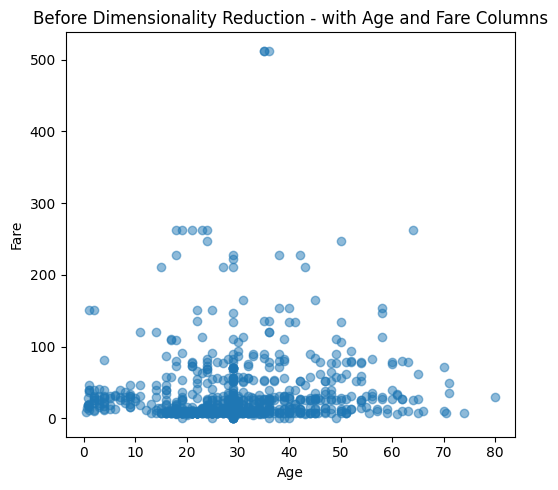

In [12]:
# plot for first situation's age and fare columns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train['Age'], X_train['Fare'], alpha=0.5)
plt.title('Before Dimensionality Reduction - with Age and Fare Columns')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.tight_layout()
plt.show()

### For PCA:

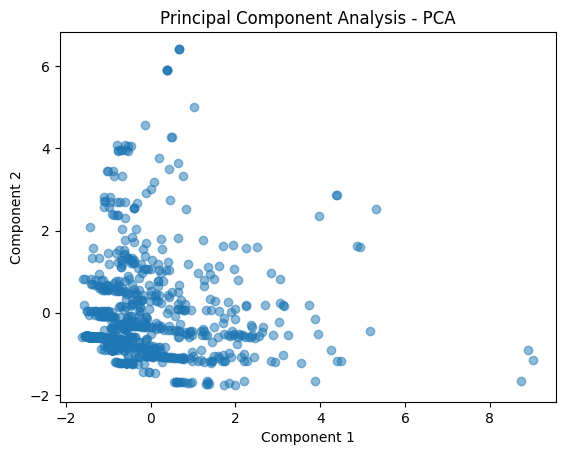

In [13]:
# pca
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('Principal Component Analysis - PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### For Kernel PCA:

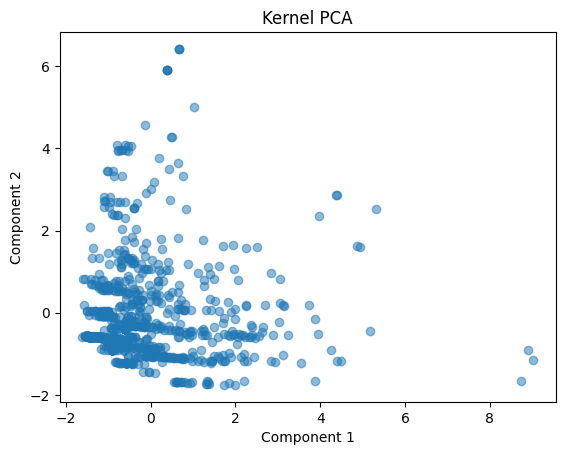

In [14]:
# kernel pca
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], alpha=0.5)
plt.title('Kernel PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### For MDS:

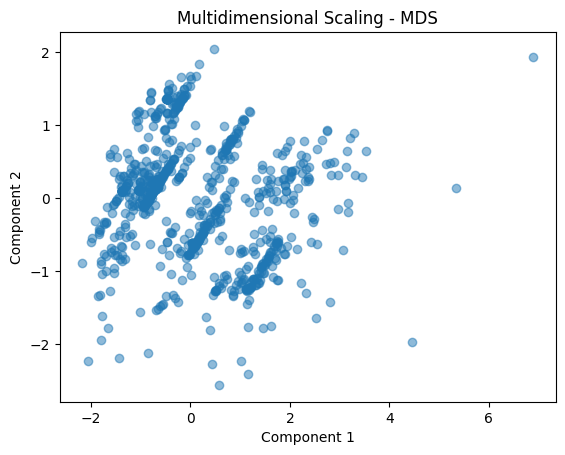

In [15]:
# mds
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], alpha=0.5)
plt.title('Multidimensional Scaling - MDS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## That's all. Thank you for reading for now. Hope that it will be helpful for you.

## Author

### Mert Kont